# Atividade 5

In [2]:
import random
import array

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from deap import benchmarks, tools, creator, base
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from numpy.random import default_rng

random.seed(42)


## Problem

In [3]:
def plot_problem_3d(
    problem,
    bounds,
    resolution=100.0,
    cmap=cm.viridis_r,
    rstride=10,
    cstride=10,
    linewidth=0.15,
    alpha=0.65,
    ax=None,
):
    "Plots a given deap benchmark problem in 3D mesh."
    (minx, miny), (maxx, maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx - minx) / resolution)
    y_range = np.arange(miny, maxy, (maxy - miny) / resolution)

    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))

    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i, j] = problem((x_range[i], y_range[j]))[0]

    if not ax:
        fig = plt.figure(figsize=(11, 6))
        ax = fig.add_subplot(projection="3d")

    cset = ax.plot_surface(
        X,
        Y,
        Z,
        cmap=cmap,
        rstride=rstride,
        cstride=cstride,
        linewidth=linewidth,
        alpha=alpha,
    )


In [4]:
def plot_problem_controur(
    problem,
    bounds,
    optimum=None,
    resolution=100.0,
    cmap=cm.viridis_r,
    rstride=1,
    cstride=10,
    linewidth=0.15,
    alpha=0.65,
    ax=None,
):
    "Plots a given deap benchmark problem as a countour plot"
    (minx, miny), (maxx, maxy) = bounds
    x_range = np.arange(minx, maxx, (maxx - minx) / resolution)
    y_range = np.arange(miny, maxy, (maxy - miny) / resolution)

    X, Y = np.meshgrid(x_range, y_range)
    Z = np.zeros((len(x_range), len(y_range)))

    for i in range(len(x_range)):
        for j in range(len(y_range)):
            Z[i, j] = problem((x_range[i], y_range[j]))[0]

    if not ax:
        fig = plt.figure(figsize=(6, 6))
        ax = fig.gca()
        ax.set_aspect("equal")
        ax.autoscale(tight=True)

    cset = ax.contourf(
        X,
        Y,
        Z,
        cmap=cmap,
        rstride=rstride,
        cstride=cstride,
        linewidth=linewidth,
        alpha=alpha,
    )

    if optimum:
        ax.plot(optimum[0], optimum[1], "bx", linewidth=4, markersize=15)


In [5]:
def plot_cov_ellipse(
    pos, cov, volume=0.99, ax=None, fc="lightblue", ec="darkblue", alpha=1, lw=1
):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    if ax is not None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

    kwrg = {"facecolor": fc, "edgecolor": ec, "alpha": alpha, "linewidth": lw}

    width, height = 2 * np.sqrt(chi2.ppf(volume, 2)) * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwrg)
    ax.add_artist(ellip)


In [6]:
current_problem = benchmarks.sphere


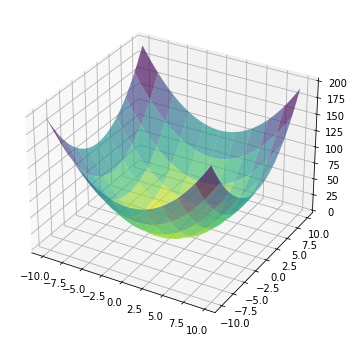

In [7]:
plot_problem_3d(current_problem, ((-10, -10), (10, 10)))


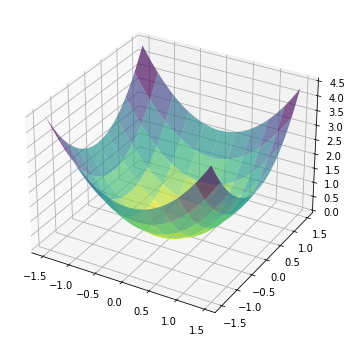

In [8]:
plot_problem_3d(current_problem, ((-1.5, -1.5), (1.5, 1.5)))


## Algoritmo

In [9]:
search_space_dims = 3

MIN_VALUE, MAX_VALUE = -100.0, 100.0
MIN_STRAT, MAX_STRAT = 0.0000001, 1.0 

In [10]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Evolutionary strategies need a location (mean)
creator.create(
    "Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None
)
# ...and a value of the strategy parameter.
creator.create("Strategy", array.array, typecode="d")


In [11]:
def init_univariate_es_ind(
    individual_class, strategy_class, size, min_value, max_value, min_strat, max_strat
):
    ind = individual_class(random.uniform(min_value, max_value) for _ in range(size))
    # we modify the instance to include the strategy in run-time.
    ind.strategy = strategy_class(
        random.uniform(min_strat, max_strat) for _ in range(size)
    )
    return ind


In [12]:
toolbox = base.Toolbox()
toolbox.register(
    "individual",
    init_univariate_es_ind,
    creator.Individual,
    creator.Strategy,
    search_space_dims,
    MIN_VALUE,
    MAX_VALUE,
    MIN_STRAT,
    MAX_STRAT,
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [13]:
ind = toolbox.individual()
pop = toolbox.population(n=3)


In [15]:
toolbox.register("mate", tools.cxESBlend, alpha=0.1)
toolbox.register("evaluate", current_problem)
toolbox.register("select", tools.selBest)


In [16]:
class eaOnePlusOneDeap:
    def __init__(self, toolbox, ngen, pop_size) -> None:
        self.__toolbox = toolbox
        self.__ngen = ngen
        self.set_pop_size(pop_size)

    def __select(self, parent, child):
        if child.fitness.values[0] < parent.fitness.values[0]:
            return child
        else:
            return parent

    def __mutate(self, individual):
        for i in individual:
            i += default_rng().normal(0, 1)
        return individual

    def set_pop_size(self, pop_size):
        self.__pop_size = pop_size

    def run(self):
        # init population
        pop = self.__toolbox.population(self.__pop_size)
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        fits = [ind.fitness.values[0] for ind in pop]
        log = []

        for g in range(self.__ngen):

            offspring = list(map(self.__mutate, pop))
            fitnesses = map(toolbox.evaluate, offspring)
            for ind, fit in zip(offspring, fitnesses):
                ind.fitness.values = fit

            for i in range(self.__pop_size):
                pop[i] = self.__select(pop[i], offspring[i])

            fits = [ind.fitness.values[0] for ind in pop]

            log.append(
                {
                    "gen": g + 1,
                    "min": np.min(fits),
                    "max": np.amax(fits),
                    "mean": np.mean(fits),
                    "std": np.std(fits),
                }
            )
        return log


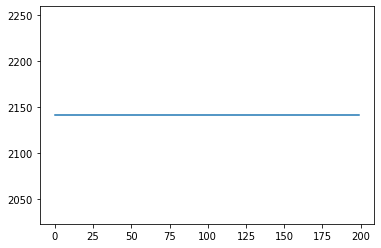

In [17]:
opo_deap = eaOnePlusOneDeap(toolbox, 200, 10)
logbook = opo_deap.run()
plt.plot([i for i in range(200)], [log["min"] for log in logbook])

## Teste População

In [18]:
pops = [i for i in range(10, 301, 5)]
results = []
opo_deap = eaOnePlusOneDeap(toolbox, 1, 100)

for n in pops:
    opo_deap.set_pop_size(n)
    logbook = opo_deap.run()
    results.append(logbook[-1]["min"])

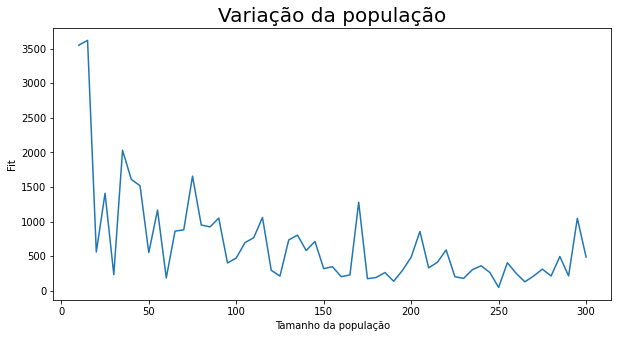

In [19]:
plt.figure(figsize=(10, 5))
plt.title("Variação da população", fontsize=20)
plt.xlabel("Tamanho da população")
plt.ylabel("Fit")
plt.plot(pops, results)

## Teste gerações 

In [31]:
pops = [i for i in range(100, 20001, 100)]
results = []
opo_deap = eaOnePlusOneDeap(toolbox, 1, 250)

for n in pops:
    opo_deap.set_pop_size(n)
    logbook = opo_deap.run()
    results.append(logbook[-1]["min"])

In [32]:
print(np.min(results))

0.49670313587420983


In [34]:
results.index(np.min(results))

158

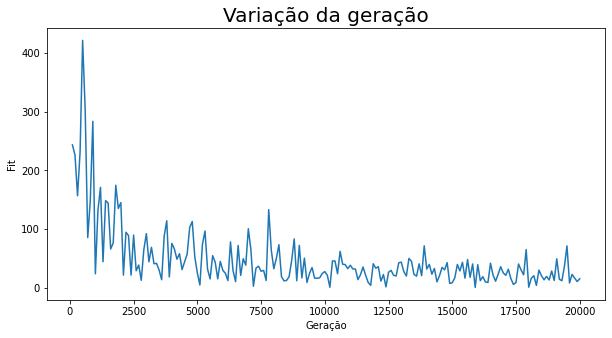

In [33]:
plt.figure(figsize=(10, 5))
plt.title("Variação da geração", fontsize=20)
plt.xlabel("Geração")
plt.ylabel("Fit")
plt.plot(pops, results)